In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
sns.set_style("whitegrid")

## **Sequential implementation**

In [2]:
seq = pd.read_csv("seq.csv", sep="\t", names=["dataset", "pairs","time"])
seq["dataset"] = seq["dataset"].replace("datasets/lsh1GB.dat", 1)
seq["dataset"] = seq["dataset"].replace("datasets/lsh5GB.dat", 5)
seq["dataset"] = seq["dataset"].replace("datasets/lsh10GB.dat", 10)
seq = seq.drop(columns=["pairs"])
seq = seq.groupby("dataset")["time"].mean()
seq = seq.reset_index()

<ipython-input-2-2f661c365d41>:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  seq["dataset"] = seq["dataset"].replace("datasets/lsh10GB.dat", 10)


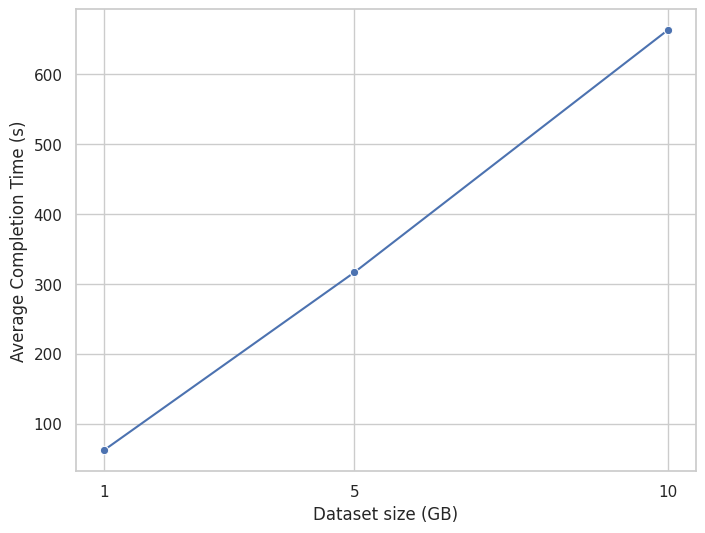

In [3]:
plt.figure(figsize=(8, 6))
ax = sns.lineplot(x="dataset", y="time", data=seq, marker="o")
ax.set_xticks([1,5,10])
ax.set_xlabel("Dataset size (GB)")
ax.set_ylabel("Average Completion Time (s)")
plt.show()


## **FF - Parallel implementation**

### **1) FF compiling flags analysis**

In [4]:
# Flags config: Deafult mapping, blocking mode
ff = pd.read_csv("ff.csv", sep="\t", header=None, names=["dataset", "n_map", "n_red", "policy", "pairs","time", "time_a2a"])
ff["dataset"] = ff["dataset"].replace("datasets/lsh1GB.dat", 1)
ff["dataset"] = ff["dataset"].replace("datasets/lsh5GB.dat", 5)
ff = ff.groupby(["dataset", "n_map", "n_red", "policy"]).mean()
ff = ff.reset_index()
ff["mapping"] = 1
ff["blocking"] = 1

# Flags config: No deafult mapping, blocking mode
ff_nm = pd.read_csv("ff_nm.csv", sep="\t", header=None, names=["dataset", "n_map", "n_red", "policy", "pairs","time", "time_a2a"])
ff_nm["dataset"] = ff_nm["dataset"].replace("datasets/lsh1GB.dat", 1)
ff_nm["dataset"] = ff_nm["dataset"].replace("datasets/lsh5GB.dat", 5)
ff_nm = ff_nm.groupby(["dataset", "n_map", "n_red", "policy"]).mean()
ff_nm = ff_nm.reset_index()
ff_nm ["mapping"] = 0
ff_nm ["blocking"] = 1

# Flags config: Deafult mapping, non-blocking mode
ff_nb = pd.read_csv("ff_nb.csv", sep="\t", header=None, names=["dataset", "n_map", "n_red", "policy", "pairs","time", "time_a2a"])
ff_nb["dataset"] = ff_nb["dataset"].replace("datasets/lsh1GB.dat", 1)
ff_nb["dataset"] = ff_nb["dataset"].replace("datasets/lsh5GB.dat", 5)
ff_nb = ff_nb.groupby(["dataset", "n_map", "n_red", "policy"]).mean()
ff_nb = ff_nb.reset_index()
ff_nb["mapping"] = 1
ff_nb["blocking"] = 0

# Flags config: No deafult mapping, non-blocking mode
ff_nm_nb = pd.read_csv("ff_nm_nb.csv", sep="\t", header=None, names=["dataset", "n_map", "n_red", "policy", "pairs","time", "time_a2a"])
ff_nm_nb["dataset"] = ff_nm_nb["dataset"].replace("datasets/lsh1GB.dat", 1)
ff_nm_nb["dataset"] = ff_nm_nb["dataset"].replace("datasets/lsh5GB.dat", 5)
ff_nm_nb = ff_nm_nb.groupby(["dataset", "n_map", "n_red", "policy"]).mean()
ff_nm_nb = ff_nm_nb.reset_index()
ff_nm_nb["mapping"] = 0
ff_nm_nb["blocking"] = 0

ff_flags = pd.concat([ff, ff_nm, ff_nb, ff_nm_nb], ignore_index=True)
ff_flags["n_node"] = ff_flags["n_map"] + ff_flags["n_red"]

<ipython-input-4-66b310bfe99d>:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ff["dataset"] = ff["dataset"].replace("datasets/lsh5GB.dat", 5)
<ipython-input-4-66b310bfe99d>:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ff_nm["dataset"] = ff_nm["dataset"].replace("datasets/lsh5GB.dat", 5)
<ipython-input-4-66b310bfe99d>:22: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the futur

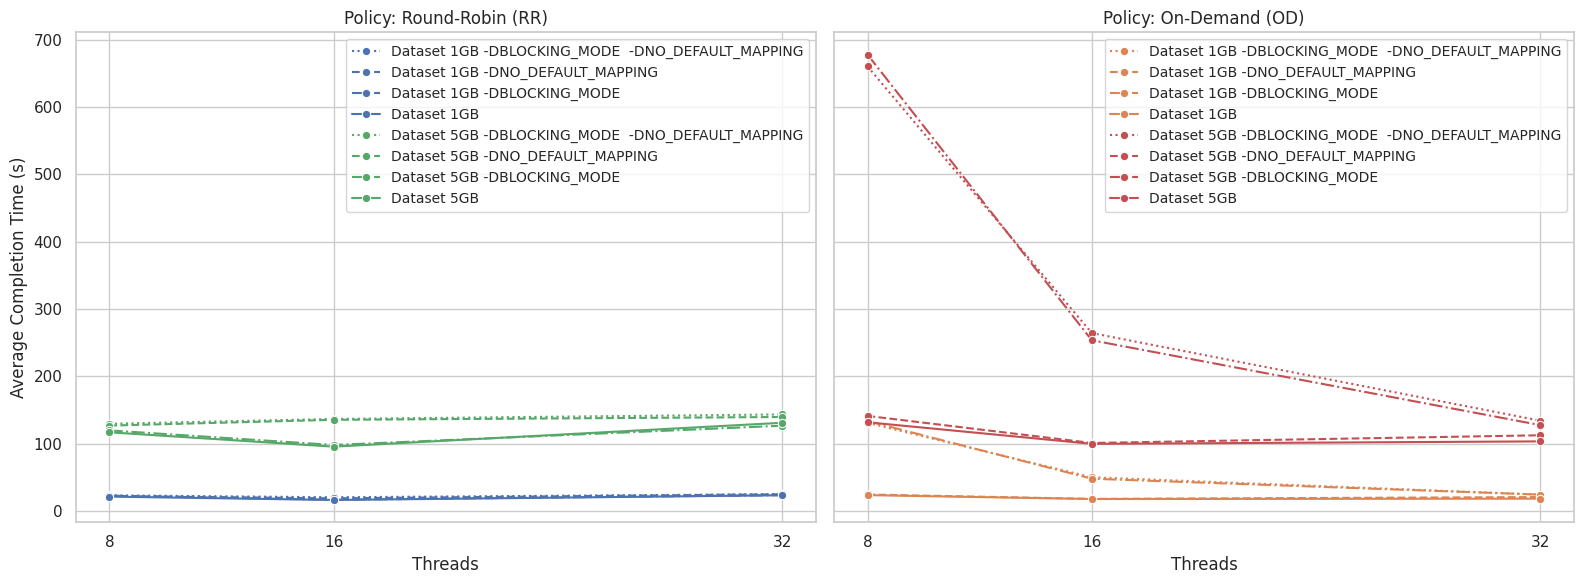

In [5]:
dataset_policy_colors = {}
color_palette = sns.color_palette(n_colors=len(ff_flags.groupby(["dataset", "policy"])))
for i, (dataset, policy) in enumerate(ff_flags.groupby(["dataset", "policy"]).groups.keys()):
    dataset_policy_colors[(dataset, policy)] = color_palette[i]

mapping_blocking_linestyles = {(1, 1): "-", (0, 1): "--",(1, 0): "-.", (0, 0): ":"}
policy_titles = {0: "Round-Robin (RR)",1: "On-Demand (OD)"}

policies = ff_flags['policy'].unique()
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

for ax, policy in zip(axes, policies):
    policy_data = ff_flags[ff_flags['policy'] == policy]
    for (dataset, _, mapping, blocking), subset in policy_data.groupby(["dataset", "policy", "mapping", "blocking"]):
        color = dataset_policy_colors[(dataset, policy)]
        linestyle = mapping_blocking_linestyles[(mapping, blocking)]
        label = f"Dataset {int(dataset)}GB"
        if blocking == 0:
            label += " -DBLOCKING_MODE "

        if mapping == 0:
            label += " -DNO_DEFAULT_MAPPING"
        line = sns.lineplot(
            x="n_node", y="time", data=subset, marker='o',
            linestyle=linestyle, color=color, label=label, ax=ax
        )
    custom_title = policy_titles.get(policy, f"Policy: {policy}")
    ax.set_xticks(ff_flags["n_node"].unique())
    ax.set_title(f"Policy: {custom_title}")
    ax.set_xlabel("Threads")
    ax.set_ylabel("Average Completion Time (s)")
    ax.legend(fontsize="small")
    ax.grid(True)
plt.tight_layout()
axes[0].set_ylabel("Average Completion Time (s)")
axes[1].set_ylabel("Average Completion Time (s)")
plt.show()


### **2) Number of mappers and reducers trade-off**

In [6]:
ff_mr = pd.read_csv("ff_MR.csv", sep="\t", header=None, names=["dataset", "n_map", "n_red", "policy", "pairs","time", "time_a2a"])
ff_mr["dataset"] = ff_mr["dataset"].replace("datasets/lsh1GB.dat", 1)
ff_mr["dataset"] = ff_mr["dataset"].replace("datasets/lsh5GB.dat", 5)
ff_mr["dataset"] = ff_mr["dataset"].replace("datasets/lsh10GB.dat", 10)
ff_mr = ff_mr.groupby(["dataset", "n_map", "n_red", "policy"]).mean()
ff_mr = ff_mr.reset_index()
ff_mr["mapping"] = 1
ff_mr["blocking"] = 1
ff_mr['n_map'] = ff_mr['n_map'].replace(9, 10)
ff_mr['n_red'] = ff_mr['n_red'].replace(7, 6)
ff_mr = ff_mr[ff_mr['dataset'] != 10]
ff_mr['n_map_n_red'] = ff_mr['n_map'].astype(str) + '-' + ff_mr['n_red'].astype(str)
#ff_mr_flags["n_node"] = ff_mr_flags["n_map"] + ff_mr_flags["n_red"]

<ipython-input-6-f7cd2fcec5d3>:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ff_mr["dataset"] = ff_mr["dataset"].replace("datasets/lsh5GB.dat", 5)


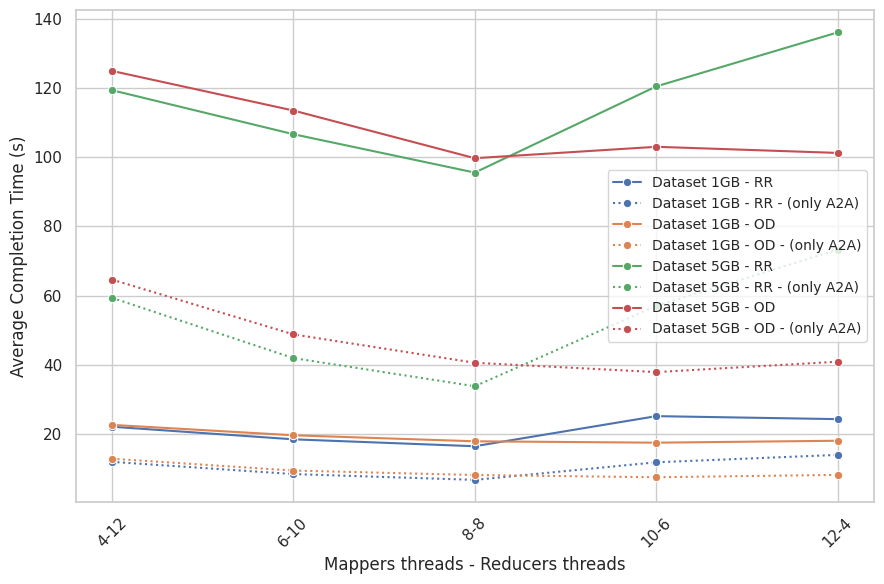

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

policy_titles = {0: "RR", 1: "OD"}
unique_pairs = ff_mr.groupby(["dataset", "policy"]).size().index
color_map = {pair: color for pair, color in zip(unique_pairs, sns.color_palette(n_colors=len(unique_pairs)))}

plt.figure(figsize=(9, 6))

for (dataset, policy), subset in ff_mr.groupby(["dataset", "policy"]):
    custom_title = policy_titles.get(policy, f"Policy: {policy}")
    color = color_map[(dataset, policy)]
    sns.lineplot(x="n_map_n_red", y="time", data=subset, marker='o', label=f"Dataset {int(dataset)}GB - {custom_title}", color=color)
    sns.lineplot(x="n_map_n_red", y="time_a2a", data=subset, marker='o', linestyle="dotted", label=f"Dataset {int(dataset)}GB - {custom_title} - (only A2A)", color=color)

plt.xlabel("Mappers threads - Reducers threads")
plt.ylabel("Average Completion Time (s)")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(fontsize="small")
plt.tight_layout()
plt.show()


### **3) Strong performance analysis**

In [8]:
ff_s = pd.read_csv("ff_strong.csv", sep="\t", header=None, names=["dataset", "n_map", "n_red", "policy", "pairs","time", "time_a2a"])
ff_s["dataset"] = ff_s["dataset"].replace("datasets/lsh1GB.dat", 1)
ff_s["dataset"] = ff_s["dataset"].replace("datasets/lsh5GB.dat", 5)
ff_s["dataset"] = ff_s["dataset"].replace("datasets/lsh10GB.dat", 10)
ff_s = ff_s.groupby(["dataset", "n_map", "n_red", "policy"]).mean()
ff_s = ff_s.reset_index()
ff_s["mapping"] = 1
ff_s["blocking"] = 1
ff_s["n_node"] = ff_s["n_map"] + ff_s["n_red"]

ff_s["dataset"] = ff_s["dataset"].replace("datasets/lsh1GB.dat", 1)
ff_s["dataset"] = ff_s["dataset"].replace("datasets/lsh5GB.dat", 5)
ff_s["dataset"] = ff_s["dataset"].replace("datasets/lsh10GB.dat", 10)
ff_s = ff_s.groupby(["dataset", "n_map", "n_red", "policy"]).mean()
ff_s = ff_s.reset_index()
ff_s["mapping"] = 1
ff_s["blocking"] = 1
ff_s["n_node"] = ff_s["n_map"] + ff_s["n_red"]

ff_s = ff_s.merge(seq, on="dataset", how="left", suffixes=("", "_seq"))
ff_par1 = ff_s[(ff_s['n_map'] == 1) & (ff_s['n_red'] == 1)][['dataset', 'policy', 'time', 'time_a2a']]
ff_par1 = ff_par1.rename(columns={'time': 'time_par1', 'time_a2a': 'time_a2a_par1'})
ff_s = pd.merge(ff_s, ff_par1, on=['dataset', 'policy'], how='left')

ff_s["speedup"] = ff_s["time_seq"] / ff_s["time"]
ff_s["par_cost"] = ff_s["time"] * ff_s["n_node"]
ff_s["efficiency"] = ff_s["time_seq"] / ff_s["par_cost"]
ff_s["scalability"] = ff_s["time_par1"] / ff_s["time"]

ff_s["speedup_a2a"] = ff_s["time_seq"] / ff_s["time_a2a"]
ff_s["par_cost_a2a"] = ff_s["time_a2a"] * ff_s["n_node"]
ff_s["efficiency_a2a"] = ff_s["time_seq"] / ff_s["par_cost_a2a"]
ff_s["scalability_a2a"] = ff_s["time_a2a_par1"] / ff_s["time_a2a"]

set2_colors = sns.color_palette(n_colors=3)
dataset_colors = {1: set2_colors[0], 5: set2_colors[1], 10: set2_colors[2]}
policy_titles = {0: "Round-Robin", 1: "On-Demand"}

<ipython-input-8-6b2f7dd97504>:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ff_s["dataset"] = ff_s["dataset"].replace("datasets/lsh10GB.dat", 10)


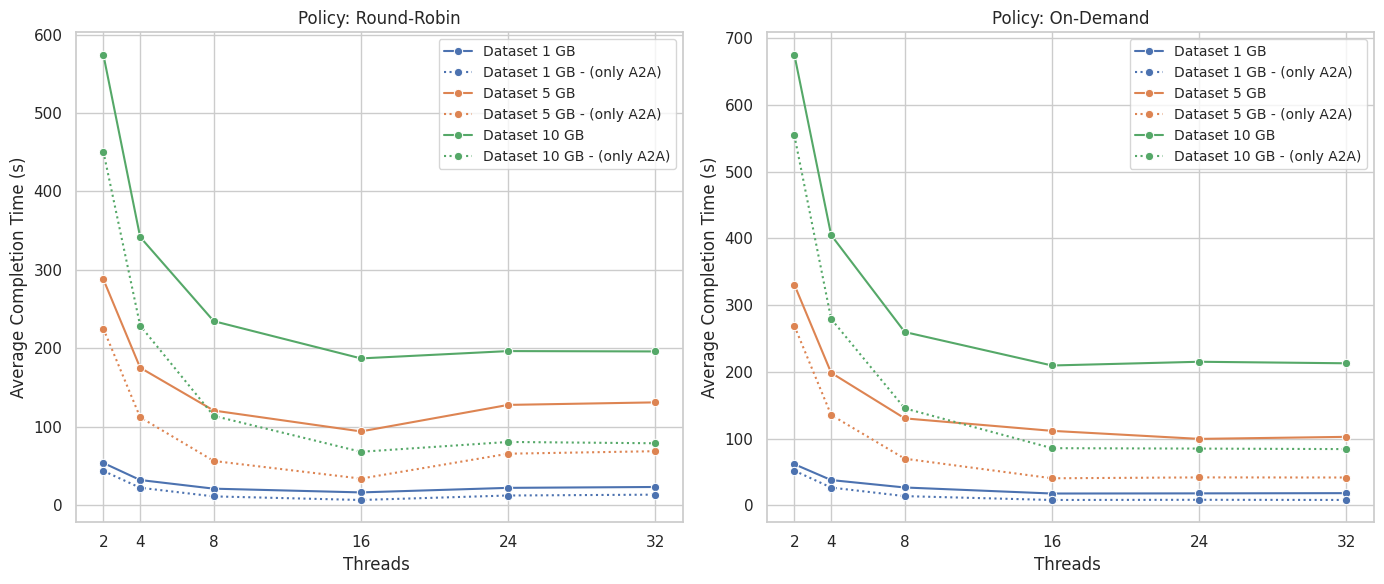

In [9]:
#@title Completion time
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
policy_values = ff_s['policy'].unique()
for i, policy in enumerate(policy_values):
    data_policy = ff_s[ff_s['policy'] == policy]
    for dataset, color in dataset_colors.items():
        data_dataset = data_policy[data_policy['dataset'] == dataset]

        sns.lineplot(x='n_node', y='time', data=data_dataset, ax=axes[i],
                     marker='o', label=f'Dataset {dataset} GB', color=color)
        sns.lineplot(x='n_node', y='time_a2a', data=data_dataset, linestyle="dotted", ax=axes[i], marker='o', label=f'Dataset {dataset} GB - (only A2A)', color=color)
    custom_title = policy_titles.get(policy, f"Policy: {policy}")
    axes[i].set_title(f"Policy: {custom_title}")
    axes[i].set_xticks(ff_s["n_node"].unique())
    axes[i].set_xlabel("Threads ")
    axes[i].set_ylabel("Average Completion Time (s)")
    axes[i].legend(fontsize="small")
plt.tight_layout()
plt.show()


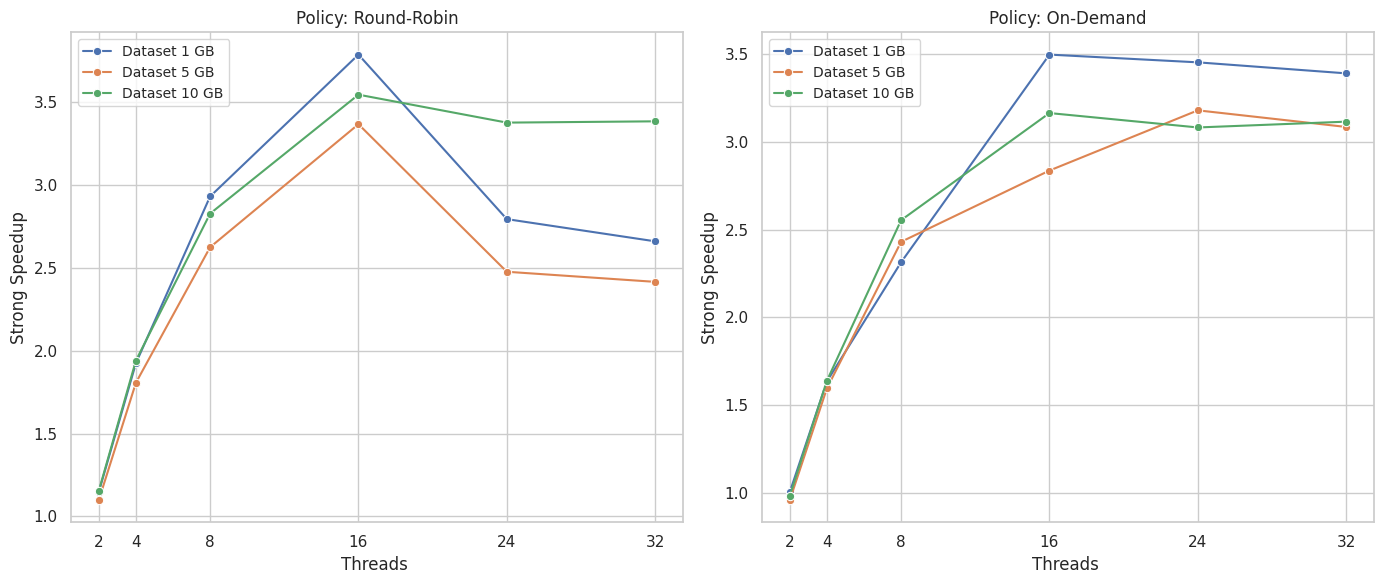

In [10]:
#@title Speeedup
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
policy_values = ff_s['policy'].unique()
for i, policy in enumerate(policy_values):
    data_policy = ff_s[ff_s['policy'] == policy]
    for dataset, color in dataset_colors.items():
        data_dataset = data_policy[data_policy['dataset'] == dataset]
        sns.lineplot(x='n_node', y='speedup', data=data_dataset, ax=axes[i],
                     marker='o', label=f'Dataset {dataset} GB', color=color)
        #sns.lineplot(x='n_node', y='speedup_a2a', data=data_dataset, linestyle="dotted", ax=axes[i],marker='o', label=f'Dataset {dataset} GB - A2A', color=color)
    #custom_title = policy_titles.get(policy, f"Policy: {policy}")
    custom_title = policy_titles.get(policy, f"Policy: {policy}")
    axes[i].set_title(f"Policy: {custom_title}")
    axes[i].set_xlabel("Threads ")
    axes[i].set_ylabel("Strong Speedup")
    axes[i].set_xticks(ff_s["n_node"].unique())
    axes[i].legend(loc='upper left', fontsize="small")
plt.tight_layout()
plt.show()

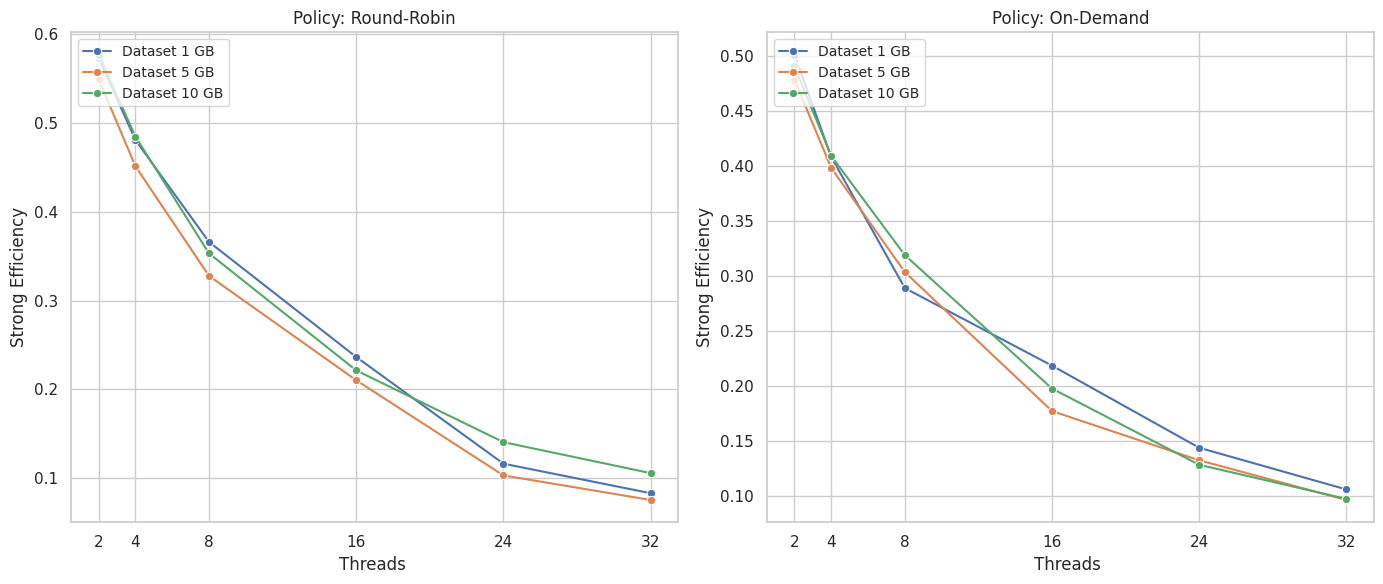

In [11]:
#@title Strong Efficiency

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
policy_values = ff_s['policy'].unique()
for i, policy in enumerate(policy_values):
    data_policy = ff_s[ff_s['policy'] == policy]
    for dataset, color in dataset_colors.items():
        data_dataset = data_policy[data_policy['dataset'] == dataset]
        sns.lineplot(x='n_node', y='efficiency', data=data_dataset, ax=axes[i],
                     marker='o', label=f'Dataset {dataset} GB', color=color)
        #sns.lineplot(x='n_node', y='efficiency_a2a', data=data_dataset, linestyle="dotted", ax=axes[i],marker='o', label=f'Dataset {dataset} GB - A2A', color=color)
    custom_title = policy_titles.get(policy, f"Policy: {policy}")
    axes[i].set_title(f"Policy: {custom_title}")
    axes[i].set_xlabel("Threads ")
    axes[i].set_ylabel("Strong Efficiency")
    axes[i].set_xticks(ff_s["n_node"].unique())
    axes[i].legend(loc='upper left', fontsize="small")
plt.tight_layout()
plt.show()

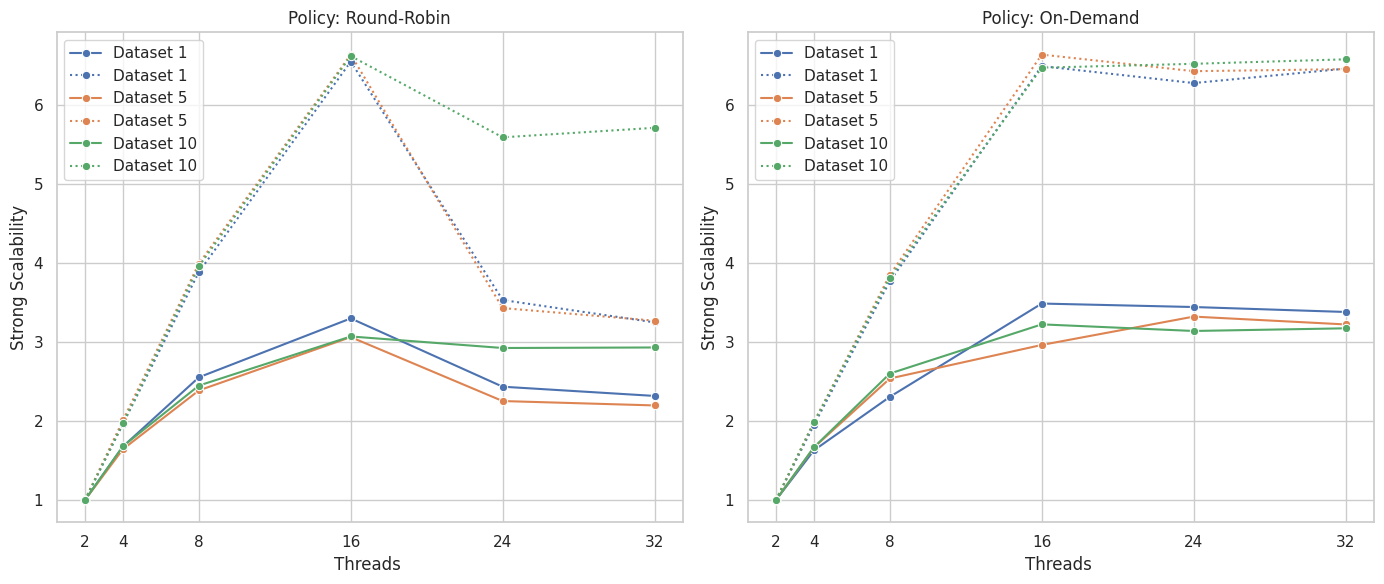

In [12]:
#@title Strong scalability
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

policy_values = ff_s['policy'].unique()
for i, policy in enumerate(policy_values):

    data_policy = ff_s[ff_s['policy'] == policy]
    for dataset, color in dataset_colors.items():
        data_dataset = data_policy[data_policy['dataset'] == dataset]

        sns.lineplot(x='n_node', y='scalability', data=data_dataset, ax=axes[i],
                     marker='o', label=f'Dataset {dataset}', color=color)
        sns.lineplot(x='n_node', y='scalability_a2a', data=data_dataset, linestyle="dotted", ax=axes[i], marker='o', label=f'Dataset {dataset}', color=color)
    custom_title = policy_titles.get(policy, f"Policy: {policy}")
    axes[i].set_title(f"Policy: {custom_title}")
    axes[i].set_xlabel("Threads ")
    axes[i].set_ylabel("Strong Scalability")
    axes[i].set_xticks(ff_s["n_node"].unique())

plt.tight_layout()
plt.show()

### **4) Weak performance analysis**

In [13]:
ff_w = pd.read_csv("ff_weak.csv", sep="\t", header=None, names=["dataset", "n_map", "n_red", "policy", "pairs","time", "time_a2a"])
ff_w["dataset"] = ff_w["dataset"].replace("datasets/lsh1GB.dat", 1)
ff_w["dataset"] = ff_w["dataset"].replace("datasets/lsh5GB.dat", 5)
ff_w["dataset"] = ff_w["dataset"].replace("datasets/lsh10GB.dat", 10)
ff_w = ff_w.groupby(["dataset", "n_map", "n_red", "policy"]).mean()
ff_w = ff_w.reset_index()
ff_w["mapping"] = 1
ff_w["blocking"] = 1
ff_w["n_node"] = ff_w["n_map"] + ff_w["n_red"]

ff_w["dataset"] = ff_w["dataset"].replace("datasets/lsh1GB.dat", 1)
ff_w["dataset"] = ff_w["dataset"].replace("datasets/lsh5GB.dat", 5)
ff_w["dataset"] = ff_w["dataset"].replace("datasets/lsh10GB.dat", 10)
ff_w = ff_w.groupby(["dataset", "n_map", "n_red", "policy"]).mean()
ff_w = ff_w.reset_index()
ff_w["mapping"] = 1
ff_w["blocking"] = 1
ff_w["n_node"] = ff_w["n_map"] + ff_w["n_red"]

ff_w = ff_w.merge(seq, on="dataset", how="left", suffixes=("", "_seq"))
ff_w = pd.merge(ff_w, ff_par1, on=['dataset', 'policy'], how='left')

ff_w["speedup"] = ff_w["time_seq"] / ff_w["time"]
ff_w["par_cost"] = ff_w["time"] * ff_w["n_node"]
ff_w["efficiency"] = ff_w["time_seq"] / ff_w["par_cost"]
ff_w["scalability"] = ff_w["time_par1"] / ff_w["time"]

ff_w["speedup_a2a"] = ff_w["time_seq"] / ff_w["time_a2a"]
ff_w["par_cost_a2a"] = ff_w["time_a2a"] * ff_w["n_node"]
ff_w["efficiency_a2a"] = ff_w["time_seq"] / ff_w["par_cost_a2a"]
ff_w["scalability_a2a"] = ff_w["time_a2a_par1"] / ff_w["time_a2a"]

set2_colors = sns.color_palette(n_colors=3)
policy_colors = {policy: set2_colors[i % len(set2_colors)] for i, policy in enumerate(ff_w['policy'].unique())}
ff_w['dataset_nnode'] = ff_w.apply(lambda row: f"{row['dataset']} GB \n {row['n_node']} threads", axis=1)

<ipython-input-13-884d7ca65293>:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ff_w["dataset"] = ff_w["dataset"].replace("datasets/lsh10GB.dat", 10)


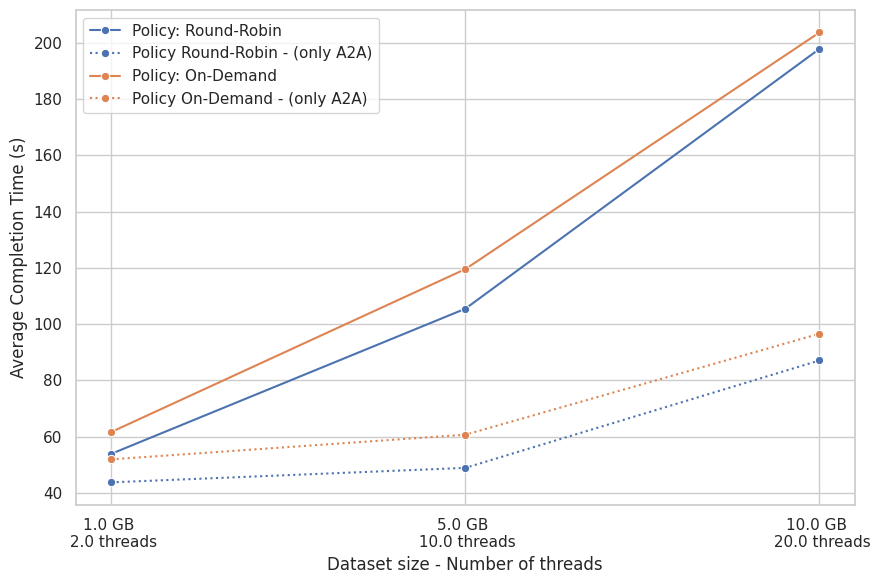

In [14]:
#@title Weak speedup
fig, ax = plt.subplots(figsize=(9, 6))

for policy in ff_w['policy'].unique():
    data_policy = ff_w[ff_w['policy'] == policy]
    color = policy_colors[policy]
    custom_title = policy_titles.get(policy, f"Policy: {policy}")
    sns.lineplot(
        x='dataset_nnode', y='time', data=data_policy, ax=ax,
        marker='o', label=f'Policy: {custom_title}', color=color
    )
    sns.lineplot(x='dataset_nnode', y='time_a2a', data=data_policy, linestyle="dotted", ax=ax, marker='o', label=f'Policy {custom_title} - (only A2A)', color=color)
ax.set_xlabel("Dataset size - Number of threads")
ax.set_ylabel("Average Completion Time (s)")
ax.legend()
plt.tight_layout()
plt.show()

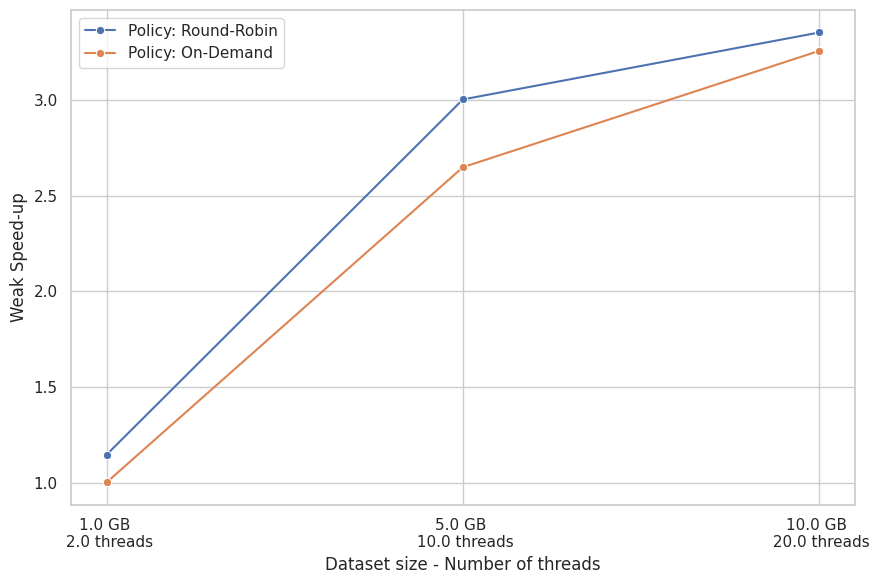

In [15]:
#@title Weak speedup
fig, ax = plt.subplots(figsize=(9, 6))

for policy in ff_w['policy'].unique():
    data_policy = ff_w[ff_w['policy'] == policy]
    color = policy_colors[policy]
    custom_title = policy_titles.get(policy, f"Policy: {policy}")
    sns.lineplot(
        x='dataset_nnode', y='speedup', data=data_policy, ax=ax,
        marker='o', label=f'Policy: {custom_title}', color=color
    )
    #sns.lineplot(x='dataset_nnode', y='speedup_a2a', data=data_policy, linestyle="dotted", ax=ax, marker='o', label=f'Policy {policy} - A2A', color=color)
ax.set_xlabel("Dataset size - Number of threads")
ax.set_ylabel("Weak Speed-up")
ax.legend()
plt.tight_layout()
plt.show()


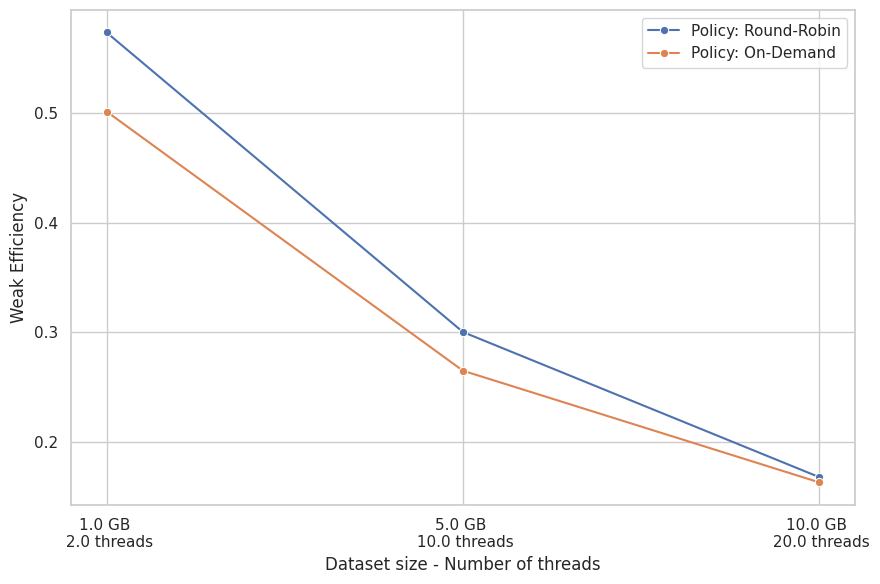

In [16]:
#@title Weak efficiency

fig, ax = plt.subplots(figsize=(9, 6))
for policy in ff_w['policy'].unique():
    data_policy = ff_w[ff_w['policy'] == policy]
    color = policy_colors[policy]
    custom_title = policy_titles.get(policy, f"Policy: {policy}")
    sns.lineplot(
        x='dataset_nnode', y='efficiency', data=data_policy, ax=ax,
        marker='o', label=f'Policy: {custom_title}', color=color
    )
    #sns.lineplot(x='dataset_nnode', y='efficiency_a2a', data=data_policy, linestyle="dotted", ax=ax,marker='o', label=f'Policy {policy} - A2A', color=color)

ax.set_xlabel("Dataset size - Number of threads")
ax.set_ylabel("Weak Efficiency")
ax.legend()
plt.tight_layout()
plt.show()

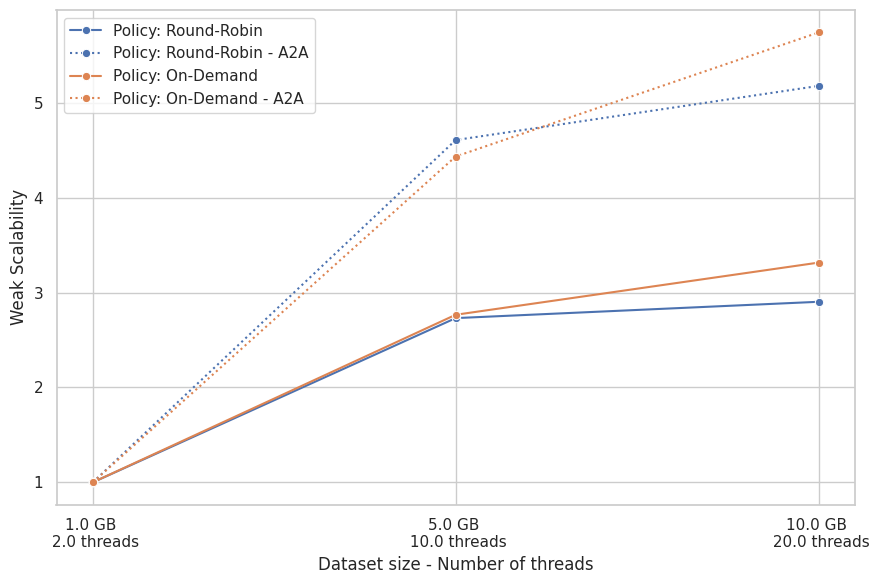

In [17]:
#@title Weak Scalability
fig, ax = plt.subplots(figsize=(9, 6))

# Plot each policy as a separate line with consistent colors
for policy in ff_w['policy'].unique():
    data_policy = ff_w[ff_w['policy'] == policy]
    color = policy_colors[policy]
    custom_title = policy_titles.get(policy, f"Policy: {policy}")
    sns.lineplot(
        x='dataset_nnode', y='scalability', data=data_policy, ax=ax,
        marker='o', label=f'Policy: {custom_title}', color=color
    )
    sns.lineplot(x='dataset_nnode', y='scalability_a2a', data=data_policy, linestyle="dotted", ax=ax, marker='o', label=f'Policy: {custom_title} - A2A', color=color)
ax.set_xlabel("Dataset size - Number of threads")
ax.set_ylabel("Weak Scalability")
ax.legend()
plt.tight_layout()
plt.show()

## **MPI - Parallel implementation**

In [18]:
#@title Load datasets

# Read data: par(1)
mpi_par = pd.read_csv("mpi_par1.csv", sep="\t", header=None)
mpi_par = mpi_par.drop(columns=mpi_par.columns[-1])
mpi_par.columns = ["exec", "dataset", "nodes", "procs", "pair", "time_in", "time_out", "time"]
mpi_par["dataset"] = mpi_par["dataset"].replace("datasets/lsh1GB.dat", 1)
mpi_par["dataset"] = mpi_par["dataset"].replace("datasets/lsh5GB.dat", 5)
mpi_par["dataset"] = mpi_par["dataset"].replace("datasets/lsh10GB.dat", 10)
mpi_par["time_io"] = mpi_par["time_in"] + mpi_par["time_out"]
mpi_par["time_alg"] = mpi_par["time"] - mpi_par["time_io"]
mpi_par["procs"] = mpi_par["procs"].astype(int)
mpi_par["nodes"] = mpi_par["nodes"].astype(int)
mpi_par = mpi_par.drop(columns=["pair", "exec"])
mpi_par = mpi_par.groupby(["dataset", "nodes", "procs"]).mean()
mpi_par = mpi_par.reset_index()

# Read data: weak
mpi_w = pd.read_csv("mpi_weak_N.csv", sep="\t", header=None)
mpi_w = mpi_w.drop(columns=mpi_w.columns[-1])
mpi_w.columns = ["exec", "dataset", "nodes", "procs", "pair", "time_in", "time_out", "time"]
mpi_w["dataset"] = mpi_w["dataset"].replace("datasets/lsh1GB.dat", 1)
mpi_w["dataset"] = mpi_w["dataset"].replace("datasets/lsh5GB.dat", 5)
mpi_w["dataset"] = mpi_w["dataset"].replace("datasets/lsh10GB.dat", 10)
mpi_w["time_io"] = mpi_w["time_in"] + mpi_w["time_out"]
mpi_w["time_alg"] = mpi_w["time"] - mpi_w["time_io"]
mpi_w["procs"] = mpi_w["procs"].astype(int)
mpi_w["nodes"] = mpi_w["nodes"].astype(int)
mpi_w = mpi_w.drop(columns=["pair", "exec"])
mpi_w = mpi_w.groupby(["dataset", "nodes", "procs"]).mean()
mpi_w = mpi_w.reset_index()

# Read data: weak
mpi_wP = pd.read_csv("mpi_weak_P.csv", sep="\t", header=None)
mpi_wP = mpi_wP.drop(columns=mpi_wP.columns[-1])
mpi_wP.columns = ["exec", "dataset", "nodes", "procs", "pair", "time_in", "time_out", "time"]
mpi_wP["dataset"] = mpi_wP["dataset"].replace("datasets/lsh1GB.dat", 1)
mpi_wP["dataset"] = mpi_wP["dataset"].replace("datasets/lsh5GB.dat", 5)
mpi_wP["dataset"] = mpi_wP["dataset"].replace("datasets/lsh10GB.dat", 10)
mpi_wP["time_io"] = mpi_wP["time_in"] + mpi_wP["time_out"]
mpi_wP["time_alg"] = mpi_wP["time"] - mpi_wP["time_io"]
mpi_wP["procs"] = mpi_wP["procs"].astype(int)
mpi_wP["nodes"] = mpi_wP["nodes"].astype(int)
mpi_wP = mpi_wP.drop(columns=["pair", "exec"])
mpi_wP = mpi_wP.groupby(["dataset", "nodes", "procs"]).mean()
mpi_wP = mpi_wP.reset_index()

mpi_s = pd.read_csv("mpi_strong_1N.csv", sep="\t", header=None)
mpi_s = mpi_s.drop(columns=mpi_s.columns[-1])
mpi_s.columns = ["exec", "dataset", "nodes", "procs", "pair", "time_in", "time_out", "time"]
mpi_s["dataset"] = mpi_s["dataset"].replace("datasets/lsh1GB.dat", 1)
mpi_s["dataset"] = mpi_s["dataset"].replace("datasets/lsh5GB.dat", 5)
mpi_s["dataset"] = mpi_s["dataset"].replace("datasets/lsh10GB.dat", 10)
mpi_s["time_io"] = mpi_s["time_in"] + mpi_s["time_out"]
mpi_s["time_alg"] = mpi_s["time"] - mpi_s["time_io"]
mpi_s["procs"] = mpi_s["procs"].astype(int)
mpi_s["nodes"] = mpi_s["nodes"].astype(int)
mpi_s = mpi_s.drop(columns=["pair", "exec"])
mpi_s = mpi_s.groupby(["dataset", "nodes", "procs"]).mean()
mpi_s = mpi_s.reset_index()

mpi_s1 = pd.read_csv("mpi_strong_1GB.csv", sep="\t", header=None)
mpi_s1 = mpi_s1.drop(columns=mpi_s1.columns[-1])
mpi_s1.columns = ["exec", "dataset", "nodes", "procs", "pair", "time_in", "time_out", "time"]
mpi_s1["dataset"] = mpi_s1["dataset"].replace("datasets/lsh1GB.dat", 1)
mpi_s1["dataset"] = mpi_s1["dataset"].replace("datasets/lsh5GB.dat", 5)
mpi_s1["dataset"] = mpi_s1["dataset"].replace("datasets/lsh10GB.dat", 10)
mpi_s1["time_io"] = mpi_s1["time_in"] + mpi_s1["time_out"]
mpi_s1["time_alg"] = mpi_s1["time"] - mpi_s1["time_io"]
mpi_s1["procs"] = mpi_s1["procs"].astype(int)
mpi_s1["nodes"] = mpi_s1["nodes"].astype(int)
mpi_s1 = mpi_s1.drop(columns=["pair", "exec"])
mpi_s1 = mpi_s1.groupby(["dataset", "nodes", "procs"]).mean()
mpi_s1 = mpi_s1.reset_index()


<ipython-input-18-4c66135725a8>:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  mpi_par["dataset"] = mpi_par["dataset"].replace("datasets/lsh10GB.dat", 10)
<ipython-input-18-4c66135725a8>:24: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  mpi_w["dataset"] = mpi_w["dataset"].replace("datasets/lsh10GB.dat", 10)
<ipython-input-18-4c66135725a8>:39: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To op

In [19]:
#@title Compute metrics: speedup, efficiency and scalability.

mpi_s = mpi_s.merge(seq, on="dataset", how="left", suffixes=("", "_seq"))
mpi_s = mpi_s.merge(mpi_par[["dataset", "time", "time_alg"]], on="dataset", how="left", suffixes=("", "_par1"))
mpi_s["speedup"] = mpi_s["time_seq"] / mpi_s["time"]
mpi_s["par_cost"] = mpi_s["time"] * mpi_s["procs"]
mpi_s["efficiency"] = mpi_s["time_seq"] / mpi_s["par_cost"]
mpi_s["scalability"] = mpi_s["time_par1"] / mpi_s["time"]

mpi_s1 = mpi_s1.merge(seq, on="dataset", how="left", suffixes=("", "_seq"))
mpi_s1 = mpi_s1.merge(mpi_par[["dataset", "time", "time_alg"]], on="dataset", how="left", suffixes=("", "_par1"))
mpi_s1["speedup"] = mpi_s1["time_seq"] / mpi_s1["time"]
mpi_s1["par_cost"] = mpi_s1["time"] * mpi_s1["procs"]
mpi_s1["efficiency"] = mpi_s1["time_seq"] / mpi_s1["par_cost"]
mpi_s1["scalability"] = mpi_s1["time_par1"] / mpi_s1["time"]

mpi_w = mpi_w.merge(seq, on="dataset", how="left", suffixes=("", "_seq"))
mpi_w = mpi_w.merge(mpi_par[["dataset", "time", "time_alg"]], on="dataset", how="left", suffixes=("", "_par1"))
mpi_w["speedup"] = mpi_w["time_seq"] / mpi_w["time"]
mpi_w["par_cost"] = mpi_w["time"] * mpi_w["procs"]
mpi_w["efficiency"] = mpi_w["time_seq"] / mpi_w["par_cost"]
mpi_w["scalability"] = mpi_w["time_par1"] / mpi_w["time"]

mpi_wP = mpi_wP.merge(seq, on="dataset", how="left", suffixes=("", "_seq"))
mpi_wP = mpi_wP.merge(mpi_par[["dataset", "time", "time_alg"]], on="dataset", how="left", suffixes=("", "_par1"))
mpi_wP["speedup"] = mpi_wP["time_seq"] / mpi_wP["time"]
mpi_wP["par_cost"] = mpi_wP["time"] * mpi_wP["procs"]
mpi_wP["efficiency"] = mpi_wP["time_seq"] / mpi_wP["par_cost"]
mpi_wP["scalability"] = mpi_wP["time_par1"] / mpi_wP["time"]

# Compute same metrics without considering time for MPI_s1 I/O operations
mpi_s1["speedup_alg"] = mpi_s1["time_seq"] / mpi_s1["time_alg"]
mpi_s1["par_cost_alg"] = mpi_s1["time_alg"] * mpi_s1["procs"]
mpi_s1["efficiency_alg"] = mpi_s1["time_seq"] / mpi_s1["par_cost_alg"]
mpi_s1["scalability_alg"] = mpi_s1["time_alg_par1"] / mpi_s1["time_alg"]

mpi_s["speedup_alg"] = mpi_s["time_seq"] / mpi_s["time_alg"]
mpi_s["par_cost_alg"] = mpi_s["time_alg"] * mpi_s["procs"]
mpi_s["efficiency_alg"] = mpi_s["time_seq"] / mpi_s["par_cost_alg"]
mpi_s["scalability_alg"] = mpi_s["time_alg_par1"] / mpi_s["time_alg"]

mpi_wP["speedup_alg"] = mpi_wP["time_seq"] / mpi_wP["time_alg"]
mpi_wP["par_cost_alg"] = mpi_wP["time_alg"] * mpi_wP["procs"]
mpi_wP["efficiency_alg"] = mpi_wP["time_seq"] / mpi_wP["par_cost_alg"]
mpi_wP["scalability_alg"] = mpi_wP["time_alg_par1"] / mpi_wP["time_alg"]

mpi_w["speedup_alg"] = mpi_w["time_seq"] / mpi_w["time_alg"]
mpi_w["par_cost_alg"] = mpi_w["time_alg"] * mpi_w["procs"]
mpi_w["efficiency_alg"] = mpi_w["time_seq"] / mpi_w["par_cost_alg"]
mpi_w["scalability_alg"] = mpi_w["time_alg_par1"] / mpi_w["time_alg"]

### **Weak performance analysis: varying number of used nodes**

In [20]:
mpi_w["procs_pernode"] = mpi_w["procs"]/mpi_w["nodes"]
mpi_w["procs_pernode"] = mpi_w["procs_pernode"].astype(int)

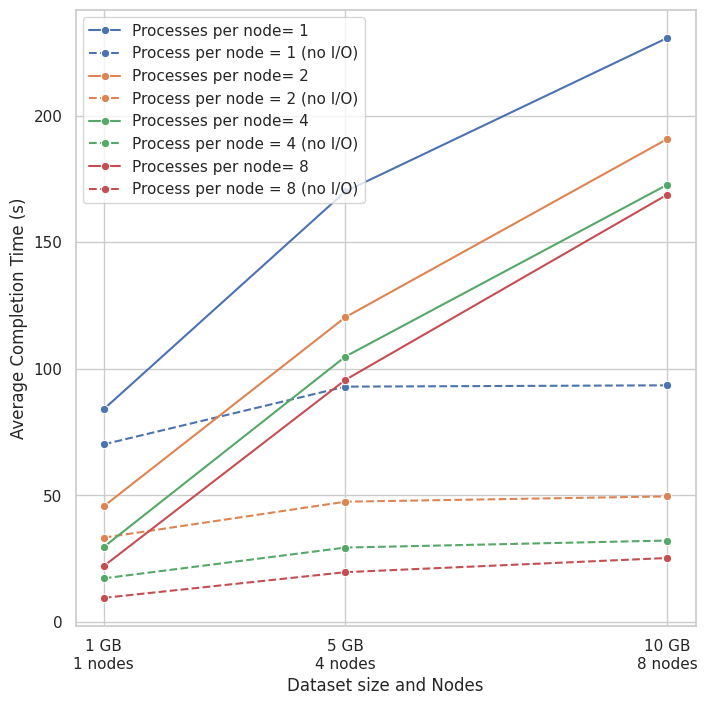

In [21]:
#@title Completion time
colors = sns.color_palette(n_colors=len(mpi_w["procs_pernode"].unique()))
plt.figure(figsize=(8,8))

for i, node_count in enumerate(mpi_w["procs_pernode"].unique()):
    subset = mpi_w[mpi_w["procs_pernode"] == node_count]
    sns.lineplot(x="nodes", y="time", data=subset, marker='o', linestyle='-', color=colors[i], label=f"Processes per node= {int(node_count)}")
    sns.lineplot(x="nodes", y="time_alg", data=subset, marker='o', linestyle='--', color=colors[i], label=f"Process per node = {int(node_count)} (no I/O)")
plt.xticks(mpi_w["nodes"].unique(), [f"{int(dataset)} GB\n{int(nodes)} nodes" for dataset, nodes in zip(mpi_w["dataset"].unique(), mpi_w["nodes"].unique())])
plt.xlabel("Dataset size and Nodes")
plt.ylabel("Average Completion Time (s)")
plt.show()

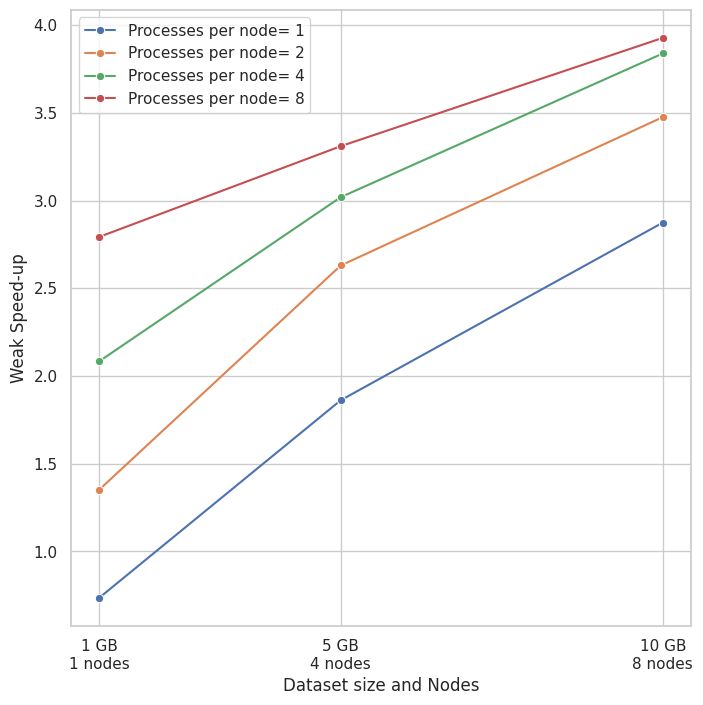

In [22]:
#@title weak speedup
colors = sns.color_palette(n_colors=len(mpi_w["procs_pernode"].unique()))
plt.figure(figsize=(8,8))

for i, node_count in enumerate(mpi_w["procs_pernode"].unique()):
    subset = mpi_w[mpi_w["procs_pernode"] == node_count]
    sns.lineplot(x="nodes", y="speedup", data=subset, marker='o', linestyle='-', color=colors[i], label=f"Processes per node= {int(node_count)}")
    #sns.lineplot(x="nodes", y="speedup_alg", data=subset, marker='o', linestyle='--', color=colors[i], label=f"Process per node = {int(node_count)} (no I/O)")
plt.xticks(mpi_w["nodes"].unique(), [f"{int(dataset)} GB\n{int(nodes)} nodes" for dataset, nodes in zip(mpi_w["dataset"].unique(), mpi_w["nodes"].unique())])
plt.xlabel("Dataset size and Nodes")
plt.ylabel("Weak Speed-up")
plt.show()

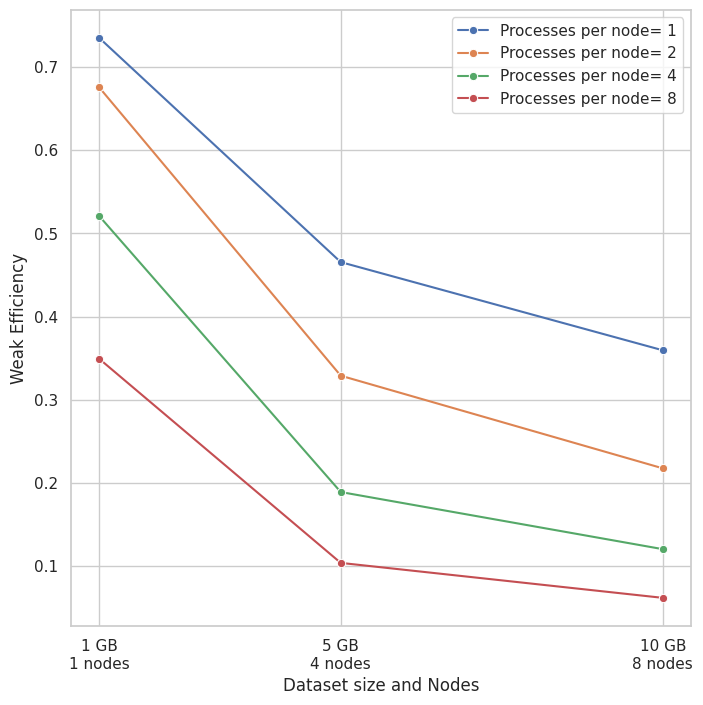

In [23]:
#@title Weak efficiency
colors = sns.color_palette(n_colors=len(mpi_w["procs_pernode"].unique()))
plt.figure(figsize=(8,8))

for i, node_count in enumerate(mpi_w["procs_pernode"].unique()):
    subset = mpi_w[mpi_w["procs_pernode"] == node_count]
    sns.lineplot(x="nodes", y="efficiency", data=subset, marker='o', linestyle='-', color=colors[i], label=f"Processes per node= {int(node_count)}")
    #sns.lineplot(x="nodes", y="efficiency_alg", data=subset, marker='o', linestyle='--', color=colors[i], label=f"Process per node = {int(node_count)} (no I/O)")
plt.xticks(mpi_w["nodes"].unique(), [f"{int(dataset)} GB\n{int(nodes)} nodes" for dataset, nodes in zip(mpi_w["dataset"].unique(), mpi_w["nodes"].unique())])
plt.xlabel("Dataset size and Nodes")
plt.ylabel("Weak Efficiency")
plt.show()

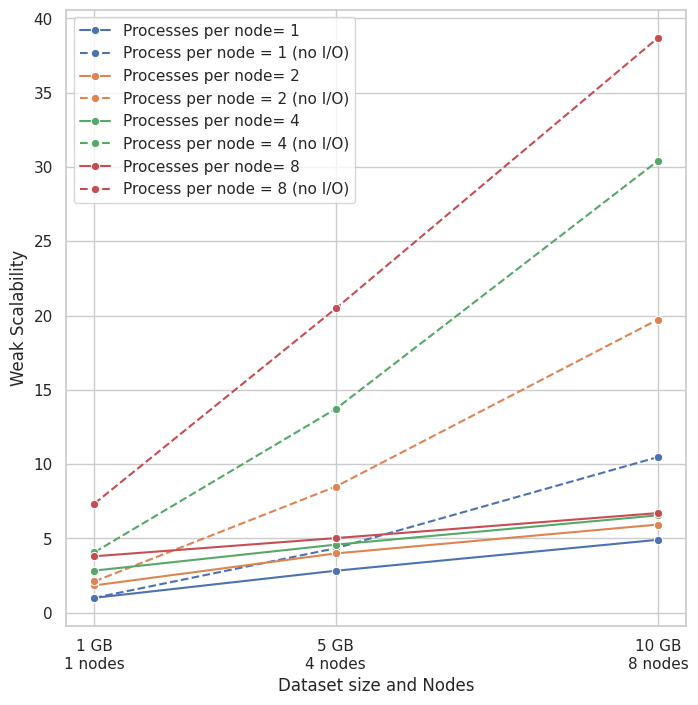

In [24]:
#@title Weak scalability
colors = sns.color_palette(n_colors=len(mpi_w["procs_pernode"].unique()))
plt.figure(figsize=(8,8))

for i, node_count in enumerate(mpi_w["procs_pernode"].unique()):
    subset = mpi_w[mpi_w["procs_pernode"] == node_count]
    sns.lineplot(x="nodes", y="scalability", data=subset, marker='o', linestyle='-', color=colors[i], label=f"Processes per node= {int(node_count)}")
    sns.lineplot(x="nodes", y="scalability_alg", data=subset, marker='o', linestyle='--', color=colors[i], label=f"Process per node = {int(node_count)} (no I/O)")
plt.xticks(mpi_w["nodes"].unique(), [f"{int(dataset)} GB\n{int(nodes)} nodes" for dataset, nodes in zip(mpi_w["dataset"].unique(), mpi_w["nodes"].unique())])
plt.xlabel("Dataset size and Nodes")
plt.ylabel("Weak Scalability")
plt.show()

### **Weak performance analysis: varying number of processes**

In [25]:
mpi_wP["procs_pernode"] = mpi_wP["procs"]/mpi_wP["nodes"]
mpi_wP["procs_pernode"] = mpi_wP["procs_pernode"].astype(int)

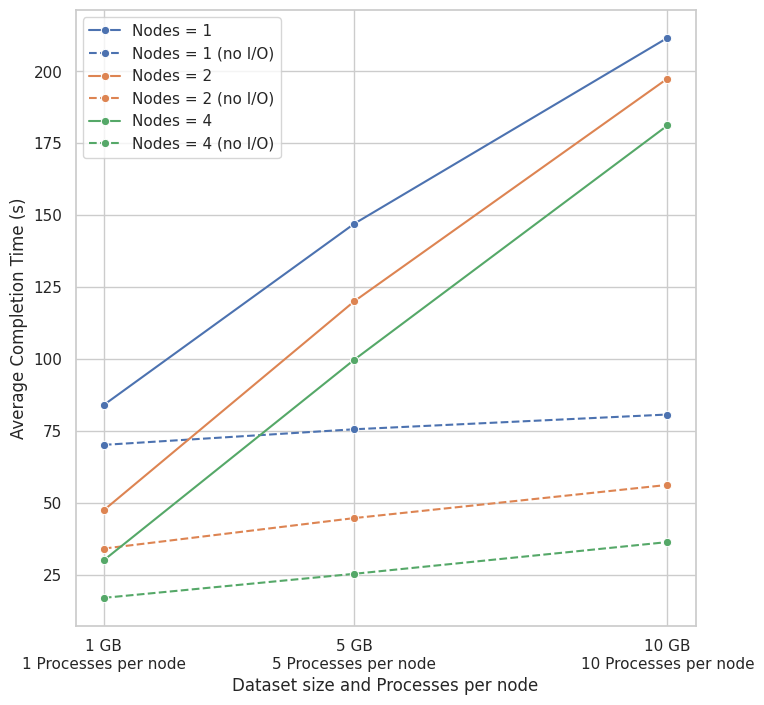

In [26]:
#@title Completion time
colors = sns.color_palette(n_colors=len(mpi_wP["nodes"].unique()))
plt.figure(figsize=(8,8))

for i, node_count in enumerate(mpi_wP["nodes"].unique()):
    subset = mpi_wP[mpi_wP["nodes"] == node_count]
    sns.lineplot(x="procs_pernode", y="time", data=subset, marker='o', linestyle='-', color=colors[i], label=f"Nodes = {int(node_count)}")
    sns.lineplot(x="procs_pernode", y="time_alg", data=subset, marker='o', linestyle='--', color=colors[i], label=f"Nodes = {int(node_count)} (no I/O)")
plt.xticks(mpi_wP["procs_pernode"].unique(), [f"{int(dataset)} GB\n{int(pnodes)} Processes per node" for dataset, pnodes in zip(mpi_wP["dataset"].unique(), mpi_wP["procs_pernode"].unique())])
plt.xlabel("Dataset size and Processes per node")
plt.ylabel("Average Completion Time (s)")
plt.show()

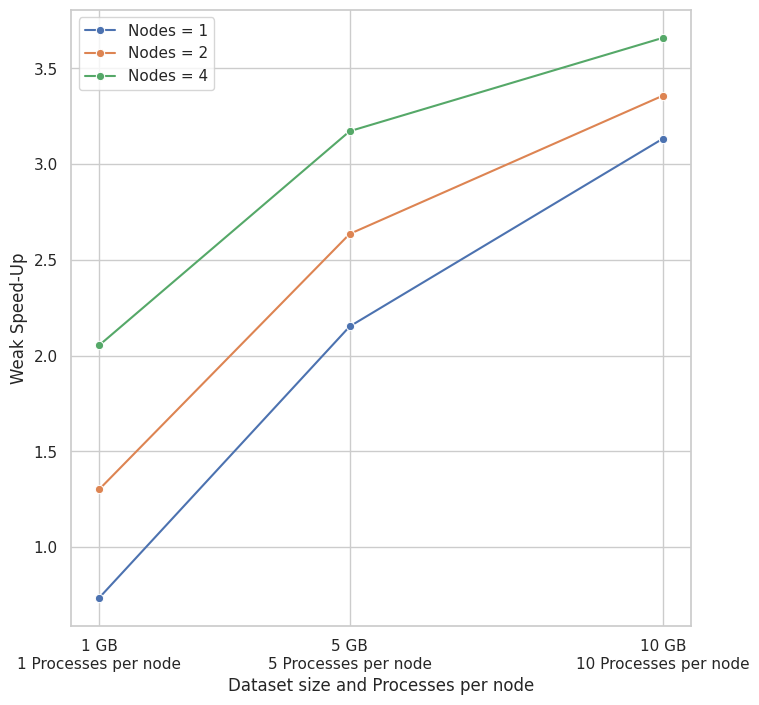

In [27]:
#@title Weak Speed-up
colors = sns.color_palette(n_colors=len(mpi_wP["nodes"].unique()))
plt.figure(figsize=(8,8))

for i, node_count in enumerate(mpi_wP["nodes"].unique()):
    subset = mpi_wP[mpi_wP["nodes"] == node_count]
    sns.lineplot(x="procs_pernode", y="speedup", data=subset, marker='o', linestyle='-', color=colors[i], label=f"Nodes = {int(node_count)}")
    #sns.lineplot(x="procs_pernode", y="speedup_alg", data=subset, marker='o', linestyle='--', color=colors[i], label=f"Nodes = {int(node_count)} (no I/O)")
plt.xticks(mpi_wP["procs_pernode"].unique(), [f"{int(dataset)} GB\n{int(pnodes)} Processes per node" for dataset, pnodes in zip(mpi_wP["dataset"].unique(), mpi_wP["procs_pernode"].unique())])
plt.xlabel("Dataset size and Processes per node")
plt.ylabel("Weak Speed-Up")
plt.show()

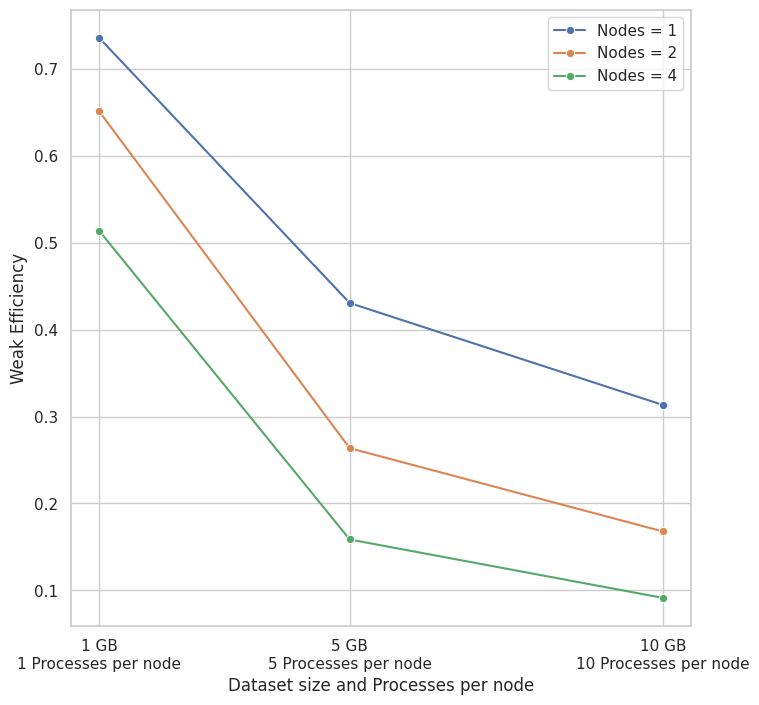

In [28]:
#@title Weak Efficiency
colors = sns.color_palette(n_colors=len(mpi_wP["nodes"].unique()))
plt.figure(figsize=(8,8))

for i, node_count in enumerate(mpi_wP["nodes"].unique()):
    subset = mpi_wP[mpi_wP["nodes"] == node_count]
    sns.lineplot(x="procs_pernode", y="efficiency", data=subset, marker='o', linestyle='-', color=colors[i], label=f"Nodes = {int(node_count)}")
    #sns.lineplot(x="procs_pernode", y="efficiency_alg", data=subset, marker='o', linestyle='--', color=colors[i], label=f"Nodes = {int(node_count)} (no I/O)")
plt.xticks(mpi_wP["procs_pernode"].unique(), [f"{int(dataset)} GB\n{int(pnodes)} Processes per node" for dataset, pnodes in zip(mpi_wP["dataset"].unique(), mpi_wP["procs_pernode"].unique())])
plt.xlabel("Dataset size and Processes per node")
plt.ylabel("Weak Efficiency")
plt.show()

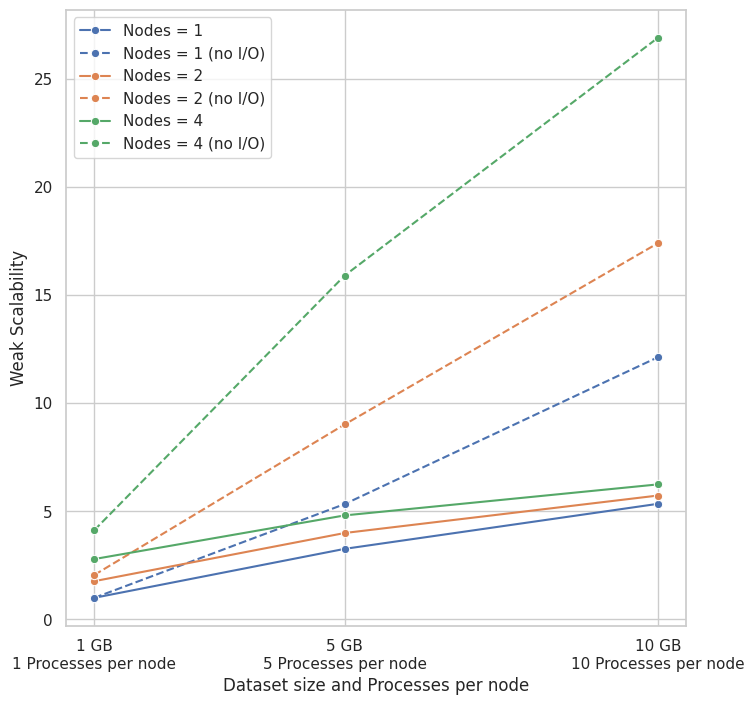

In [29]:
#@title Weak Scalability
colors = sns.color_palette(n_colors=len(mpi_wP["nodes"].unique()))
plt.figure(figsize=(8,8))

for i, node_count in enumerate(mpi_wP["nodes"].unique()):
    subset = mpi_wP[mpi_wP["nodes"] == node_count]
    sns.lineplot(x="procs_pernode", y="scalability", data=subset, marker='o', linestyle='-', color=colors[i], label=f"Nodes = {int(node_count)}")
    sns.lineplot(x="procs_pernode", y="scalability_alg", data=subset, marker='o', linestyle='--', color=colors[i], label=f"Nodes = {int(node_count)} (no I/O)")
plt.xticks(mpi_wP["procs_pernode"].unique(), [f"{int(dataset)} GB\n{int(pnodes)} Processes per node" for dataset, pnodes in zip(mpi_wP["dataset"].unique(), mpi_wP["procs_pernode"].unique())])
plt.xlabel("Dataset size and Processes per node")
plt.ylabel("Weak Scalability")
plt.show()

### **Strong performance analysis: 1GB dataset**

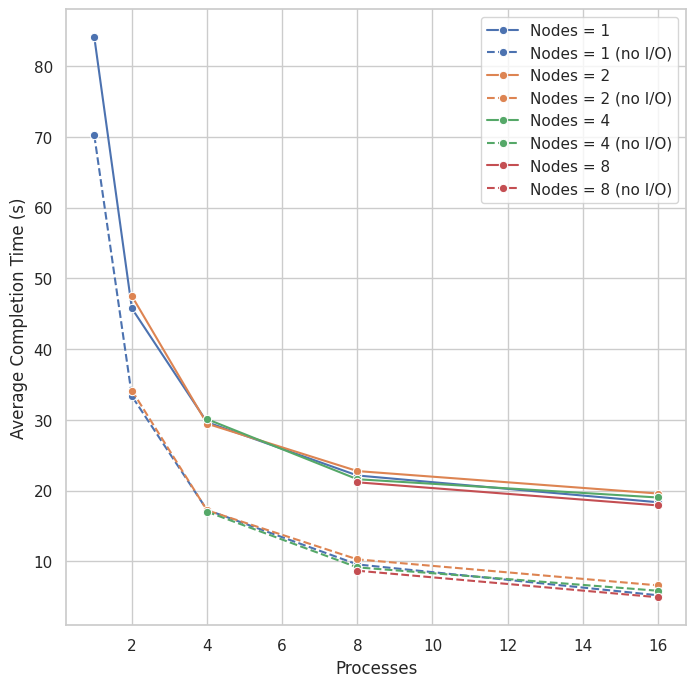

In [30]:
#@title Completion time
colors = sns.color_palette(n_colors=len(mpi_s1["nodes"].unique()))
plt.figure(figsize=(8, 8))

for i, node_count in enumerate(mpi_s1["nodes"].unique()):
    subset = mpi_s1[mpi_s1["nodes"] == node_count]
    sns.lineplot(x="procs", y="time", data=subset, marker='o', linestyle='-', color=colors[i], label=f"Nodes = {int(node_count)}")
    sns.lineplot(x="procs", y="time_alg", data=subset, marker='o', linestyle='--', color=colors[i], label=f"Nodes = {int(node_count)} (no I/O)")

plt.xlabel("Processes")
plt.ylabel("Average Completion Time (s)")
plt.show()

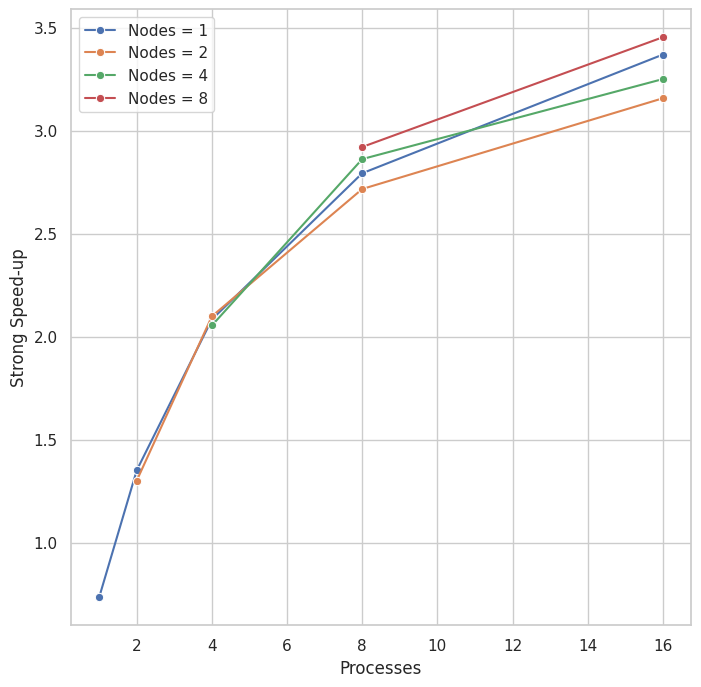

In [31]:
#@title Strong speedup
colors = sns.color_palette(n_colors=len(mpi_s1["nodes"].unique()))
plt.figure(figsize=(8, 8))

for i, node_count in enumerate(mpi_s1["nodes"].unique()):
    subset = mpi_s1[mpi_s1["nodes"] == node_count]
    sns.lineplot(x="procs", y="speedup", data=subset, marker='o', linestyle='-', color=colors[i], label=f"Nodes = {int(node_count)}")
    #sns.lineplot(x="procs", y="speedup_alg", data=subset, marker='o', linestyle='--', color=colors[i], label=f"Nodes = {int(node_count)} (no I/O)")

plt.xlabel("Processes")
plt.ylabel("Strong Speed-up")
plt.show()

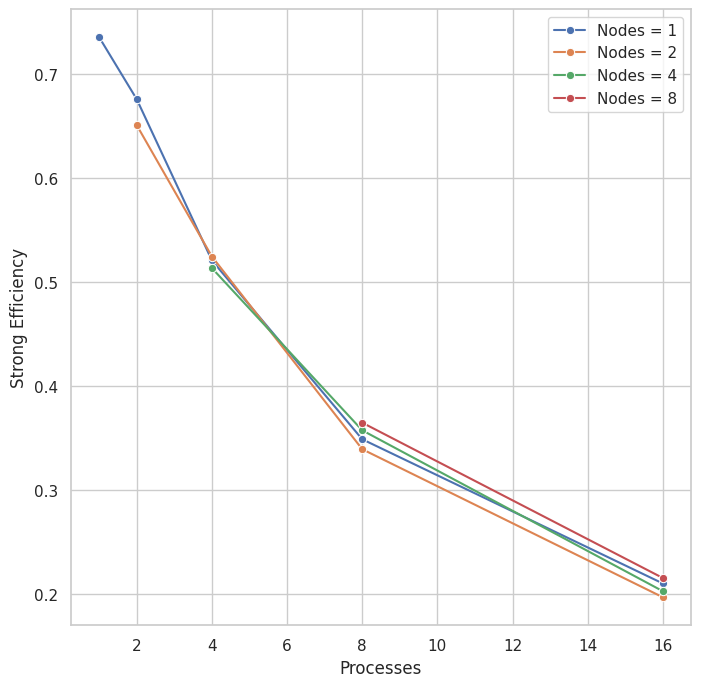

In [32]:
#@title Strong efficiency
colors = sns.color_palette( n_colors=len(mpi_s1["nodes"].unique()))
plt.figure(figsize=(8, 8))

for i, node_count in enumerate(mpi_s1["nodes"].unique()):
    subset = mpi_s1[mpi_s1["nodes"] == node_count]
    sns.lineplot(x="procs", y="efficiency", data=subset, marker='o', linestyle='-', color=colors[i], label=f"Nodes = {int(node_count)}")
    #sns.lineplot(x="procs", y="efficiency_alg", data=subset, marker='o', linestyle='--', color=colors[i], label=f"Nodes = {int(node_count)} (no I/O)")

plt.xlabel("Processes")
plt.ylabel("Strong Efficiency")
plt.show()



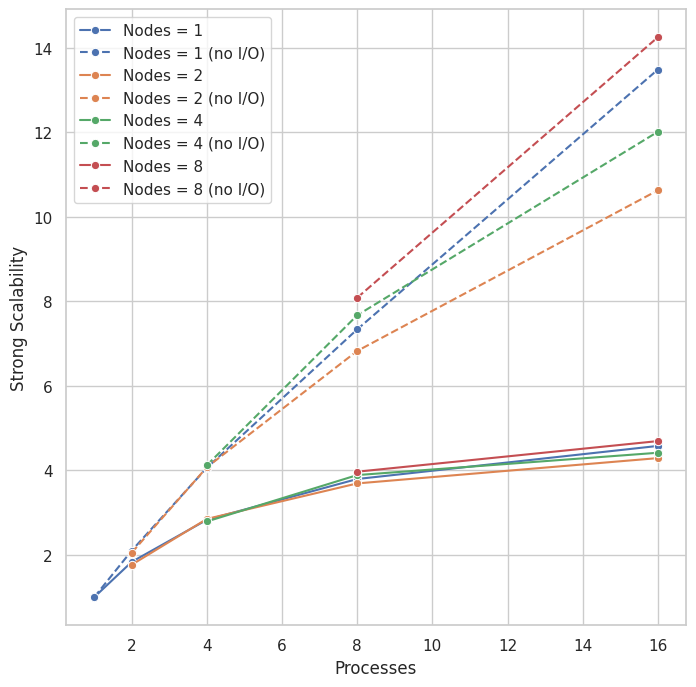

In [33]:
#@title Scalability
colors = sns.color_palette(n_colors=len(mpi_s1["nodes"].unique()))
plt.figure(figsize=(8, 8))

for i, node_count in enumerate(mpi_s1["nodes"].unique()):
    subset = mpi_s1[mpi_s1["nodes"] == node_count]
    sns.lineplot(x="procs", y="scalability", data=subset, marker='o', linestyle='-', color=colors[i], label=f"Nodes = {int(node_count)}")
    sns.lineplot(x="procs", y="scalability_alg", data=subset, marker='o', linestyle='--', color=colors[i], label=f"Nodes = {int(node_count)} (no I/O)")

plt.xlabel("Processes")
plt.ylabel("Strong Scalability")
plt.show()

### **Strong performance analysis: 1 node**

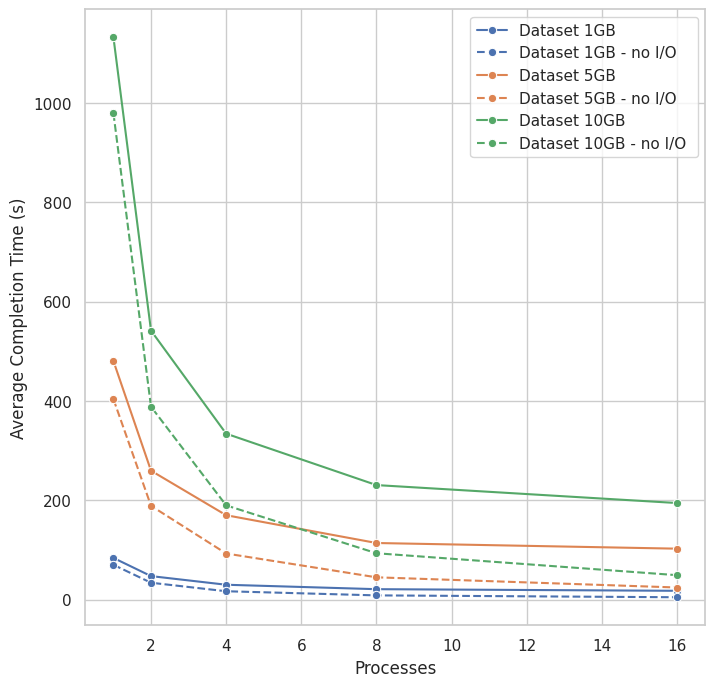

In [34]:
#@title Strong speedup

colors = sns.color_palette(n_colors=3)
plt.figure(figsize=(8, 8))
for i, dataset in enumerate(mpi_s["dataset"].unique()):
  subset = mpi_s[mpi_s["dataset"] == dataset]
  sns.lineplot(x="procs", y="time", data=subset, marker='o', linestyle='-', color=colors[i], label=f"Dataset {int(dataset)}GB")
  sns.lineplot(x="procs", y="time_alg", data=subset, marker='o', linestyle='--', color=colors[i], label=f"Dataset {int(dataset)}GB - no I/O ")

plt.xlabel("Processes")
plt.ylabel("Average Completion Time (s)")
plt.grid(True)
plt.legend()
plt.show()

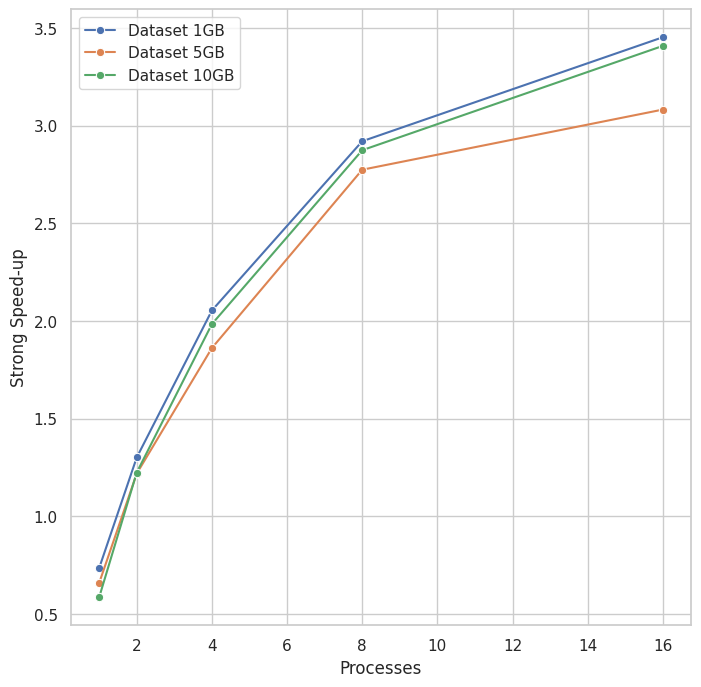

In [35]:
#@title Strong speedup

colors = sns.color_palette(n_colors=3)
plt.figure(figsize=(8, 8))
for i, dataset in enumerate(mpi_s["dataset"].unique()):
  subset = mpi_s[mpi_s["dataset"] == dataset]
  sns.lineplot(x="procs", y="speedup", data=subset, marker='o', linestyle='-', color=colors[i], label=f"Dataset {int(dataset)}GB")
  #sns.lineplot(x="procs", y="speedup_alg", data=subset, marker='o', linestyle='--', color=colors[i], label=f"Dataset {int(dataset)}GB - no I/O ")

plt.xlabel("Processes")
plt.ylabel("Strong Speed-up")
plt.grid(True)
plt.legend()
plt.show()

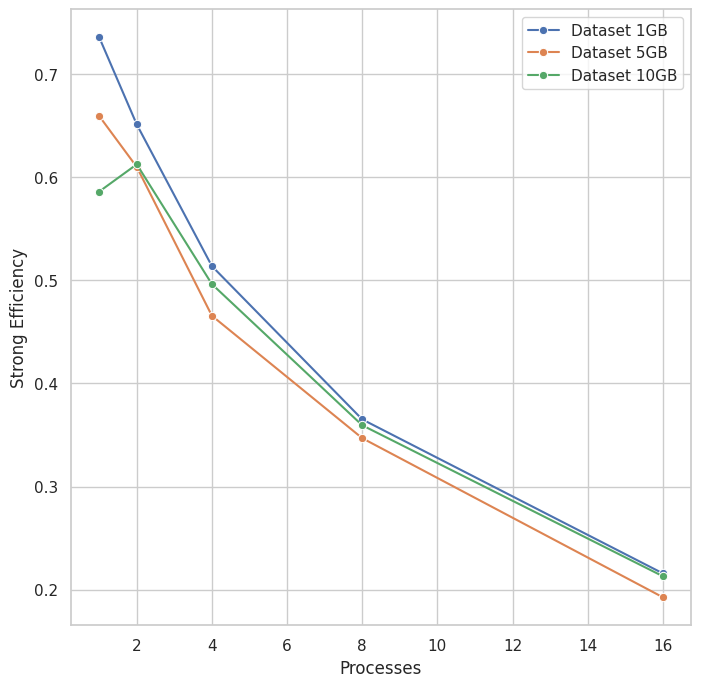

In [36]:
#@title Strong efficiency
colors = sns.color_palette(n_colors=3)
plt.figure(figsize=(8, 8))

for i, dataset in enumerate(mpi_s["dataset"].unique()):
  subset = mpi_s[mpi_s["dataset"] == dataset]
  sns.lineplot(x="procs", y="efficiency", data=subset, marker='o', linestyle='-', color=colors[i], label=f"Dataset {int(dataset)}GB")
  #sns.lineplot(x="procs", y="efficiency_alg", data=subset, marker='o', linestyle='--', color=colors[i], label=f"Dataset {int(dataset)}GB - no I/O ")

plt.xlabel("Processes")
plt.ylabel("Strong Efficiency")
plt.grid(True)
plt.legend()
plt.show()



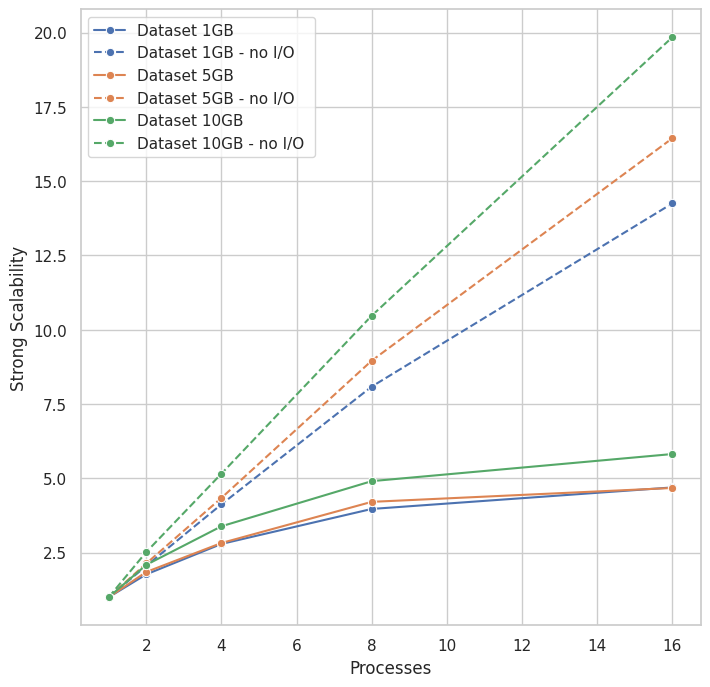

In [37]:
#@title Strong Scalability
colors = sns.color_palette(n_colors=3)
plt.figure(figsize=(8, 8))

for i, dataset in enumerate(mpi_s["dataset"].unique()):
  subset = mpi_s[mpi_s["dataset"] == dataset]
  sns.lineplot(x="procs", y="scalability", data=subset, marker='o', linestyle='-', color=colors[i], label=f"Dataset {int(dataset)}GB")
  sns.lineplot(x="procs", y="scalability_alg", data=subset, marker='o', linestyle='--', color=colors[i], label=f"Dataset {int(dataset)}GB - no I/O ")

plt.xlabel("Processes")
plt.ylabel("Strong Scalability")
plt.grid(True)
plt.legend()
plt.show()

## **MPI + OMP - Parallel implementation**

In [38]:
#@title Load datasets

# Read data: par(1)
mpi_omp_par = pd.read_csv("mpi_omp_par1.csv", sep="\t", header=None)
mpi_omp_par = mpi_omp_par.drop(columns=mpi_omp_par.columns[-1])
mpi_omp_par.columns = ["exec", "dataset", "nodes", "procs", "pair", "time_in", "time_out", "time"]
mpi_omp_par["dataset"] = mpi_omp_par["dataset"].replace("datasets/lsh1GB.dat", 1)
mpi_omp_par["dataset"] = mpi_omp_par["dataset"].replace("datasets/lsh5GB.dat", 5)
mpi_omp_par["dataset"] = mpi_omp_par["dataset"].replace("datasets/lsh10GB.dat", 10)
mpi_omp_par["time_io"] = mpi_omp_par["time_in"] + mpi_omp_par["time_out"]
mpi_omp_par["time_alg"] = mpi_omp_par["time"] - mpi_omp_par["time_io"]
mpi_omp_par["procs"] = mpi_omp_par["procs"].astype(int)
mpi_omp_par["nodes"] = mpi_omp_par["nodes"].astype(int)
mpi_omp_par["threads"] = 1
mpi_omp_par = mpi_omp_par.drop(columns=["pair", "exec"])
mpi_omp_par = mpi_omp_par.groupby(["dataset", "nodes", "procs", "threads"]).mean()
mpi_omp_par = mpi_omp_par.reset_index()


# Read data
mpi_omp = pd.read_csv("mpi_omp.csv", sep="\t", header=None)
mpi_omp = mpi_omp.drop(columns=mpi_omp.columns[-1])
mpi_omp.columns = ["exec", "dataset", "nodes", "procs","threads", "pair", "time_in", "time_out", "time"]
mpi_omp["dataset"] = mpi_omp["dataset"].replace("datasets/lsh1GB.dat", 1)
mpi_omp["dataset"] = mpi_omp["dataset"].replace("datasets/lsh5GB.dat", 5)
mpi_omp["dataset"] = mpi_omp["dataset"].replace("datasets/lsh10GB.dat", 10)
mpi_omp["time_io"] = mpi_omp["time_in"] + mpi_omp["time_out"]
mpi_omp["time_alg"] = mpi_omp["time"] - mpi_omp["time_io"]
mpi_omp["procs"] = mpi_omp["procs"].astype(int)
mpi_omp["nodes"] = mpi_omp["nodes"].astype(int)
mpi_omp = mpi_omp.drop(columns=["pair", "exec"])
mpi_omp = mpi_omp.groupby(["dataset", "nodes", "procs", "threads"]).mean()
mpi_omp = mpi_omp.reset_index()

<ipython-input-38-9622488a37f9>:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  mpi_omp_par["dataset"] = mpi_omp_par["dataset"].replace("datasets/lsh10GB.dat", 10)
<ipython-input-38-9622488a37f9>:26: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  mpi_omp["dataset"] = mpi_omp["dataset"].replace("datasets/lsh10GB.dat", 10)


In [39]:
#@title Compute metrics: speedup, efficiency and scalability.

mpi_omp = mpi_omp.merge(seq, on="dataset", how="left", suffixes=("", "_seq"))
mpi_omp = mpi_omp.merge(mpi_omp_par[["dataset", "time", "time_alg"]], on="dataset", how="left", suffixes=("", "_par1"))
mpi_omp["speedup"] = mpi_omp["time_seq"] / mpi_omp["time"]
mpi_omp["par_cost"] = mpi_omp["time"] * (mpi_omp["procs"] * mpi_omp["threads"])
mpi_omp["efficiency"] = mpi_omp["time_seq"] / mpi_omp["par_cost"]
mpi_omp["scalability"] = mpi_omp["time_par1"] / mpi_omp["time"]

# Compute same metrics without considering time for I/O operations
mpi_omp["speedup_alg"] = mpi_omp["time_seq"] / mpi_omp["time_alg"]
mpi_omp["par_cost_alg"] = mpi_omp["time_alg"] * mpi_omp["procs"]
mpi_omp["efficiency_alg"] = mpi_omp["time_seq"] / mpi_omp["par_cost_alg"]
mpi_omp["scalability_alg"] = mpi_omp["time_alg_par1"] / mpi_omp["time_alg"]

mpi_omp_strong = mpi_omp[(mpi_omp['dataset'] == 1) & (mpi_omp['threads'] != 1)]
mpi_omp_weak = mpi_omp.drop(mpi_omp_strong.index)

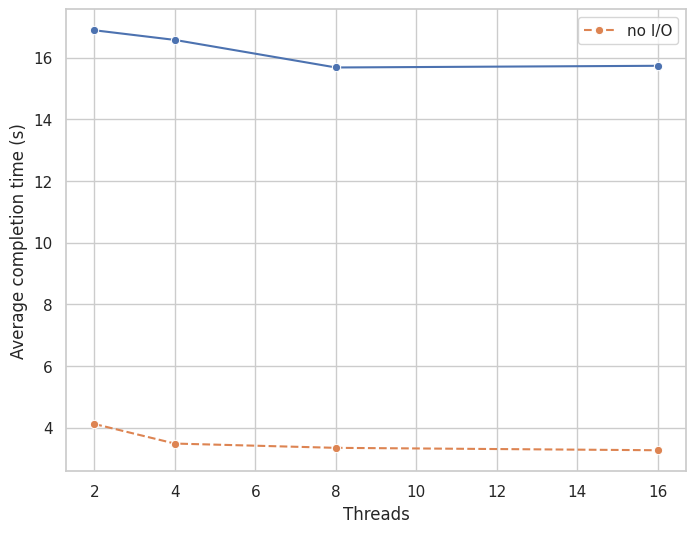

In [45]:
plt.figure(figsize=(8, 6))
sns.lineplot(x="threads", y="time", data=mpi_omp_strong, marker='o')
sns.lineplot(x="threads", y="time_alg", data=mpi_omp_strong, linestyle="dashed", marker='o', label="no I/O")
plt.xlabel("Threads")
plt.ylabel("Average completion time (s)")
plt.show()

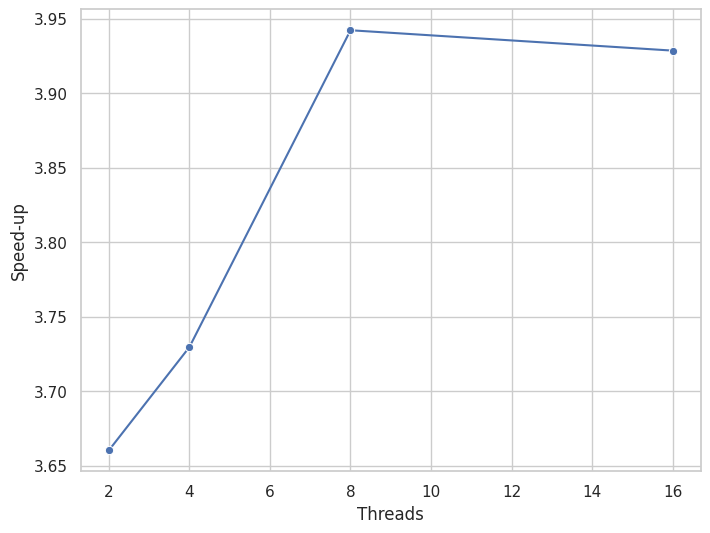

In [41]:
plt.figure(figsize=(8, 6))
sns.lineplot(x="threads", y="speedup", data=mpi_omp_strong, marker='o')
plt.xlabel("Threads")
plt.ylabel("Speed-up")
plt.show()

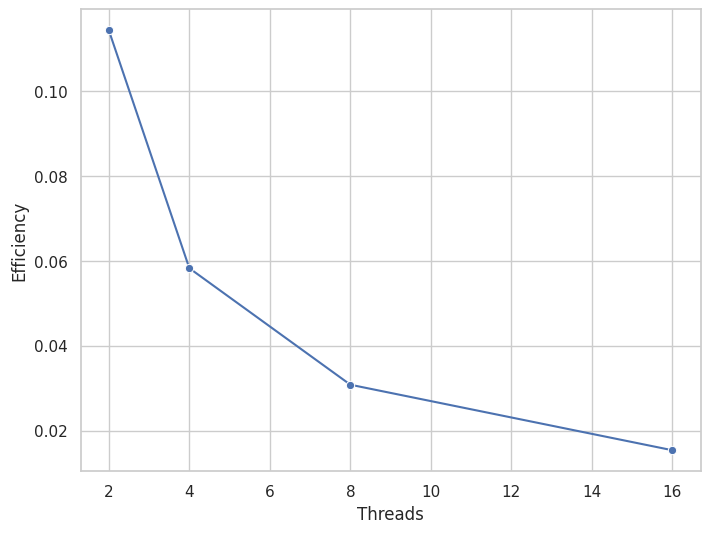

In [42]:
plt.figure(figsize=(8, 6))
sns.lineplot(x="threads", y="efficiency", data=mpi_omp_strong, marker='o')
plt.xlabel("Threads")
plt.ylabel("Efficiency")
plt.show()

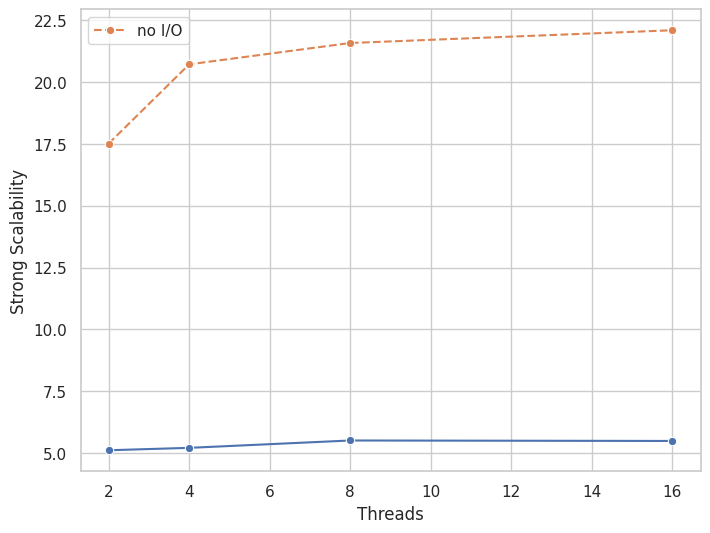

In [43]:
plt.figure(figsize=(8, 6))
sns.lineplot(x="threads", y="scalability", data=mpi_omp_strong, marker='o')
sns.lineplot(x="threads", y="scalability_alg", data=mpi_omp_strong, linestyle="dashed", marker='o', label="no I/O")
plt.xlabel("Threads")
plt.ylabel("Strong Scalability")
plt.show()

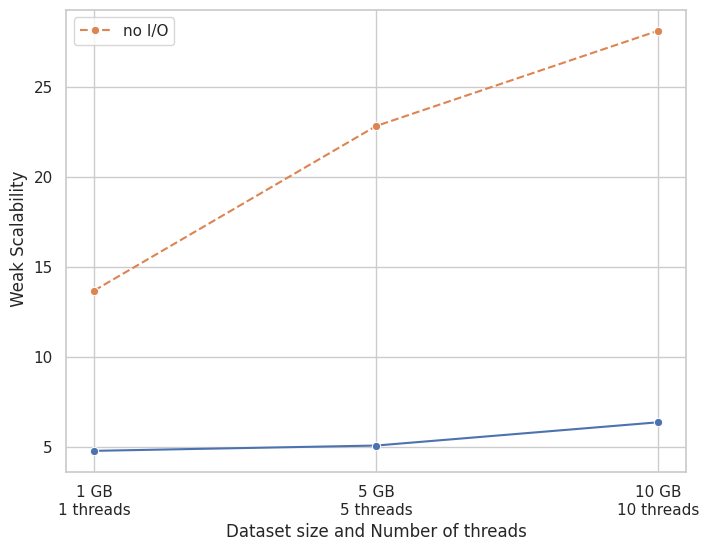

In [44]:
plt.figure(figsize=(8, 6))

mpi_omp_weak['dataset_threads'] = mpi_omp_weak['dataset'].astype(str) + ' GB\n' + mpi_omp_weak['threads'].astype(str) + ' threads'
sns.lineplot(x='dataset_threads', y='scalability', data=mpi_omp_weak, marker='o')
sns.lineplot(x='dataset_threads', y='scalability_alg', data=mpi_omp_weak, marker='o', linestyle="dashed",  label="no I/O")

plt.xlabel("Dataset size and Number of threads")
plt.ylabel(" Weak Scalability")
plt.show()